# Adaptive Inflation Simulator

If adaptive inflation was adopted today, what would the baking rights look like 6 cycles later?

Made with TzKT API.

In [8]:
import requests
import json
import datetime

# query baker alias from tzkt (tzstats does not have it)

tzkt_account_json = requests.get("https://api.tzkt.io/v1/delegates/?select=address,alias,balance,stakingBalance,delegatedBalance,frozenDeposit,frozenDepositLimit&limit=10000&active=true")
bakers = tzkt_account_json.json()


headLevel = requests.get("https://api.tzkt.io/v1/head").json()['level']


stats = requests.get(f"https://api.tzkt.io/v1/statistics?level={headLevel}").json()
def tezify(mutez_amt):
    return f"{int(mutez_amt/1000000):,} tez"

print(f"Total supply is {tezify(stats[0]['totalSupply'])}")

Total supply is 951,682,554 tez


This is the distribution of baking rights without adaptive inflation:


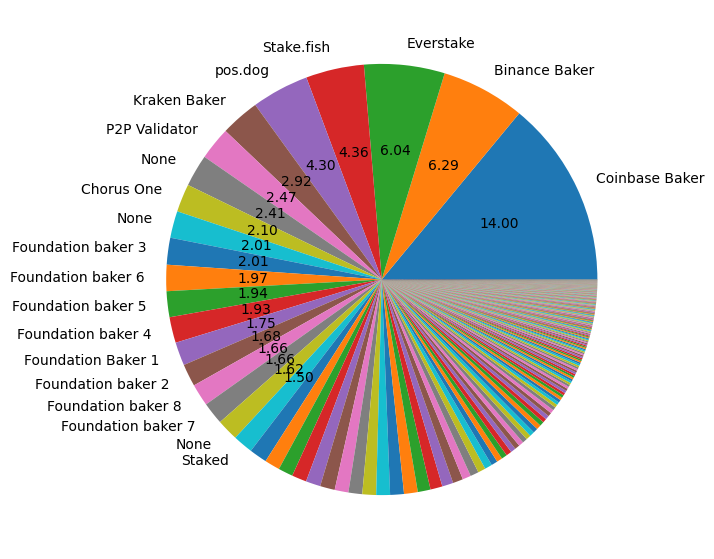

In [12]:
import pandas as pd
#Organize upgrade results in a table compatible with Pandas DataFrame


results_pn = {'alias': [],
              'balance':[],
              'delegatedBalance_int':[],
              #'delegatedBalance':[],
              #'frozenDeposit':[],
              'frozenDepositLimit':[],
              'X_b':[],
              'Y_b':[],
              'shareOfRights':[],
              'stakingBalance': [],
             }

results_index = []

totalDeposit = 0
totalDelegation = 0

for b in bakers:
    results_pn['alias'].append(b['alias'])
    results_pn['delegatedBalance_int'].append(b['delegatedBalance'])
    results_pn['stakingBalance'].append(b['stakingBalance'])
    results_pn['balance'].append(tezify(b['balance']))
    results_pn['frozenDepositLimit'].append(tezify(b['frozenDepositLimit'] or 0))
    X_b = (min(b['frozenDepositLimit'], b['balance']) if b['frozenDepositLimit'] else b['balance'])
    totalDeposit += X_b
    Y_b = min(10*X_b, b['delegatedBalance'])
    totalDelegation += Y_b
    results_pn['X_b'].append(tezify(X_b))
    results_pn['Y_b'].append(tezify(Y_b))

denominator = 2 * totalDeposit + totalDelegation

for b in bakers:
    X_b = (min(b['frozenDepositLimit'], b['balance']) if b['frozenDepositLimit'] else b['balance'])
    Y_b = min(10*X_b, b['delegatedBalance'])
    shareOfRights = (2 * X_b + Y_b) / denominator
    results_pn['shareOfRights'].append(shareOfRights)
    if shareOfRights > 0.014:    
        results_index.append(b['alias'])
    else:
        results_index.append("")
        
# Displaying original stake without adaptive inflation

pd.set_option('display.max_rows', None)
#pd.set_option('precision', 0)

df = pd.DataFrame(results_pn, index = results_index)
df = df.sort_values(by=['delegatedBalance_int'], ascending=False)

df_regular_inflation = pd.DataFrame(results_pn, index = results_index)
df_regular_inflation = df.sort_values(by=['stakingBalance'], ascending=False)


def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1.4 else ''

print("This is the distribution of baking rights without adaptive inflation:")

plot = df_regular_inflation.plot.pie(y='stakingBalance', figsize=(7, 7), legend=False,  autopct=my_autopct ,label="")


Total deposit: X = 118,749,575 tez
Total delegation: Y = 587,297,417 tez
2* X + Y = 824,796,567 tez


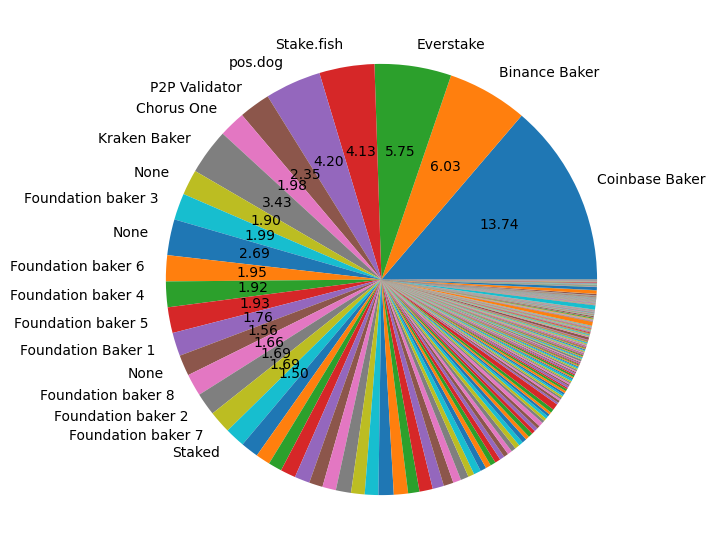

In [13]:
import pandas as pd


print(f"Total deposit: X = {tezify(totalDeposit)}")

print(f"Total delegation: Y = {tezify(totalDelegation)}")

print(f"2* X + Y = {tezify(denominator)}")

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1.4 else ''

plot = df.plot.pie(y='shareOfRights', figsize=(7, 7), legend=False,  autopct=my_autopct ,label="")

#from IPython.display import display, HTML
#display(df)